## Clustering Seismic tomographic models

Seismic tomography is a powerful way of imaging the properties of Earth's interior structure by visualising the variation in **seismic wave velocity**. The general rule of thumb is that:
- Hot materials have lower seismic waves speeds
- Cold materials have higher seismic waves speeds

Performing seismic tomography is a computationally complex process involving linear regression to find the best fitting seismic velocity for each part of a model of the Earth.

Today, we're going to analyse existing seismic tomography models in a process called **tectonic regionalisation** using **kmeans clustering**.

In [1]:
# Packages to read/open SEMUCB model
import numpy as np
import matplotlib.pyplot as plt

# packages for k-means cluster analysis
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Packages to plot map
import cartopy.crs as ccrs
import matplotlib.colors as colors

# Interpolate moho depth
from scipy import interpolate

import xarray as xr

We can start off with a synthetic dataset to test how k-means works. 

We use `make_blobs` to create a dataset of points with their assigned labels.

In [2]:
features, true_labels = make_blobs(
    n_samples=200,
    centers=3,
    cluster_std=2.75,
    random_state=42
)

Let's take at look at the output of `make_blobs`.

In [3]:
print(features[:5])
print(true_labels[:5])

[[  9.77075874   3.27621022]
 [ -9.71349666  11.27451802]
 [ -6.91330582  -9.34755911]
 [-10.86185913 -10.75063497]
 [ -8.50038027  -4.54370383]]
[1 0 2 2 2]


Now we can visualise this.

<font color=goldenrod>**_Code for you to write_**</font>

Plot a scatter plot of `features` with the colour being set by the `true_labels` value

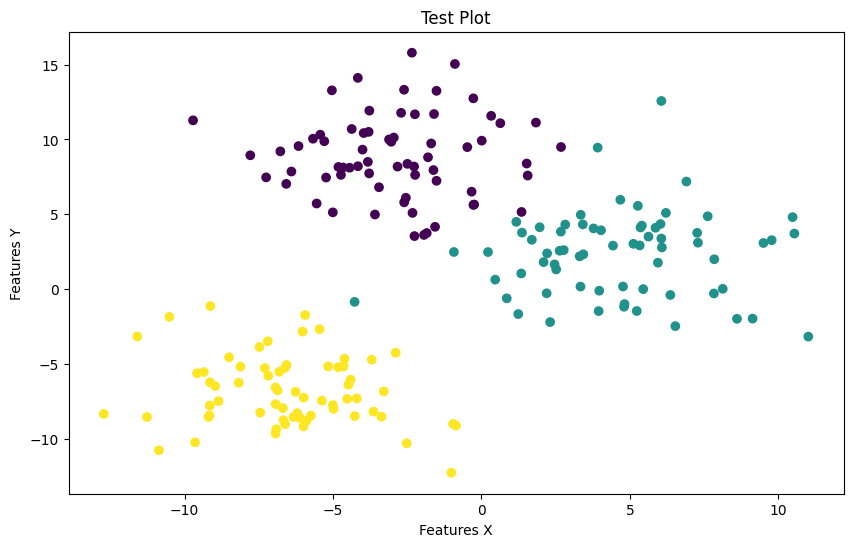

In [4]:
plt.figure(figsize=(10,6))
plt.scatter(features[:,0], features[:,1], c=true_labels)
plt.title('Test Plot')
plt.xlabel('Features X')
plt.ylabel('Features Y')
plt.show()

We can see that we have 3 clusters, as set in our `make_blobs` function.

As we saw with kneighbors in our supervised learning problem, datasets often contain numerical features with different units and magnitudes, such as parts per million and percent. A machine learning algorithm would give greater importance to the larger number with larger variance, such as 400 parts per million versus 4 percent.

However, our machine learning algorithms need to consider all features equally, so we much transform them to the same scale, called feature scaling. Feature scaling is an important pre-processing step for most distance-based machine learning algorithms (like kmeans and kneighbors) and it can have a large impact on the performance of the algorithm.

In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

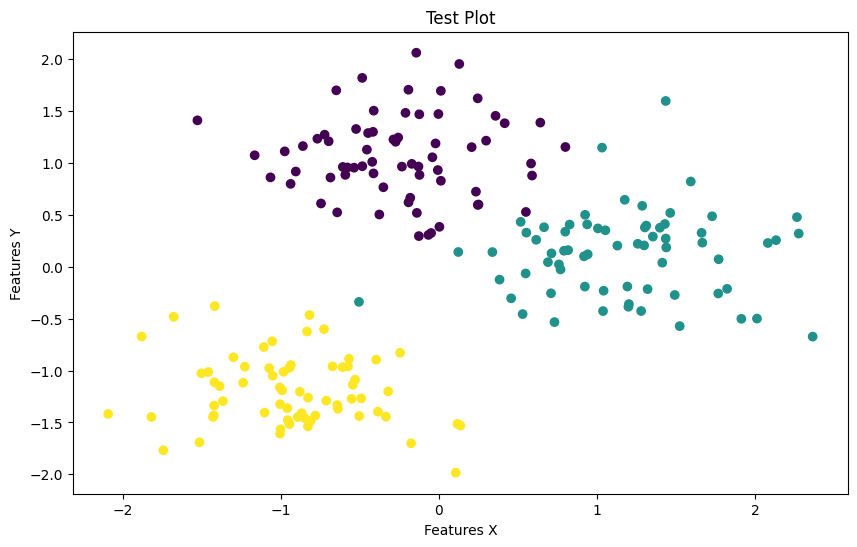

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=true_labels)
plt.title('Test Plot')
plt.xlabel('Features X')
plt.ylabel('Features Y')
plt.show()

<font color=goldenrod>**_Code for you to write_**</font>

Show the first 5 rows of `features` and of `scaled_features` to compare these two.

Let's look at how KMeans operates.

In [7]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init='auto',
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='lloyd',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

    For an example of how to choose an optimal value for `n_clusters` refer to
    :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to the overall inertia. This technique speeds up             convergence. The algorithm imple

Now we initialise the kmeans clustering algorithm. We will use `n_clusters=3`, since we know that's the correct answer.

In [8]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)


Now we apply this to our `scaled_features` dataset with `.fit`.

In [9]:
kmeans.fit(scaled_features)

,n_clusters,3
,init,'random'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


The `kmeans` object now has a lot of properties that we can use. We can see these using the docstring.

In [10]:
kmeans?

Type:        KMeans
String form: KMeans(init='random', n_clusters=3, n_init=10, random_state=42)
File:        ~/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py
Docstring:  
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

    For an example of how to choose an optimal value for `n_clusters` refer to
    :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to the overall inertia. This technique speeds up             convergence. The algorithm implemented is "greedy k-means++". It

For example, `kmeans.labels_` contains the suggest labels for each datapoint.

In [11]:
print(kmeans.labels_[:5])

[0 1 2 2 2]


Let's see how this worked.

<font color=goldenrod>**_Code for you to write_**</font>

Plot either `features` or `scaled_features` and colour the datapoints by `kmeans.labels_`.

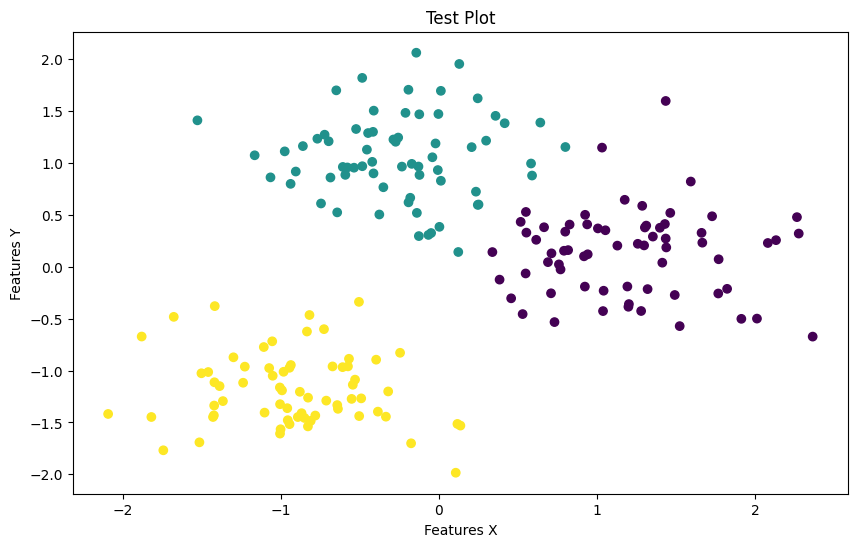

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=kmeans.labels_)
plt.title('Test Plot')
plt.xlabel('Features X')
plt.ylabel('Features Y')
plt.show()

This worked really well. We found those three clusters without telling the code where they were.

Let's look at some more details, such as:
- how good the fit was, defined as the `inertia_`. This is the value that the code is trying to reduce to determine the best fit. It's calculated as the **Sum of the Squared Errors**, or SSE, similar to in our linear regression.
- where the centres or **centroids** of each cluster are with `cluster_centers_`
- and how many calculations the code took to find these positions with `n_iter_`

In [13]:
# The lowest SSE value
print(kmeans.inertia_)

 # Final locations of the centroid
print(kmeans.cluster_centers_)

 # The number of iterations required to converge
print(kmeans.n_iter_)

74.57960106819853
[[ 1.19539276  0.13158148]
 [-0.25813925  1.05589975]
 [-0.91941183 -1.18551732]]
10


<font color=goldenrod>**_Code for you to write_**</font>

Plot the `scaled_features` and `cluster_centers_`.
Make sure to plot the `cluster_centers_` markers larger and in a different shape so that you can see them.

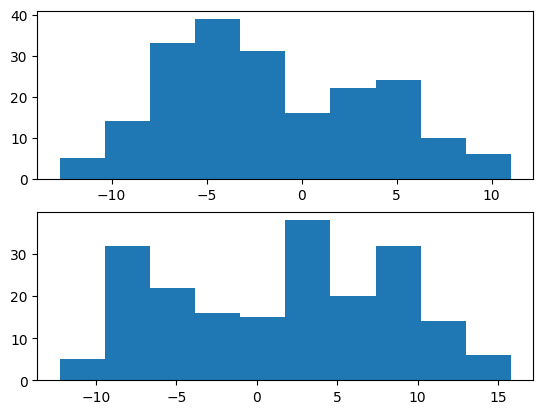

In [27]:
fig, ax = plt.subplots(2,1)
ax[0].hist(features[:,0])
ax[1].hist(features[:,1])
plt.show()

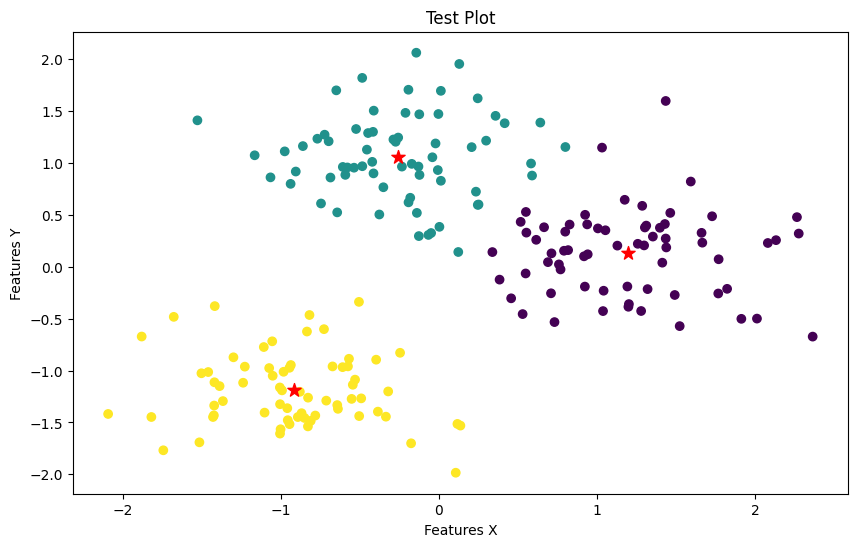

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker='*', color='red' ,s=100)
plt.title('Test Plot')
plt.xlabel('Features X')
plt.ylabel('Features Y')
plt.show()

We don't always know the best number of clusters to use. We can **use a loop** to try different numbers of clusters to find the lowest Sum of the Squared Errors.

<font color=goldenrod>**_Code for you to write_**</font>

- Create new `KMeans` objects with different numbers of `n_clusters` between 1 and 10 (inclusive) and repeat the fit
- Plot the SSE versus the number of clusters tried

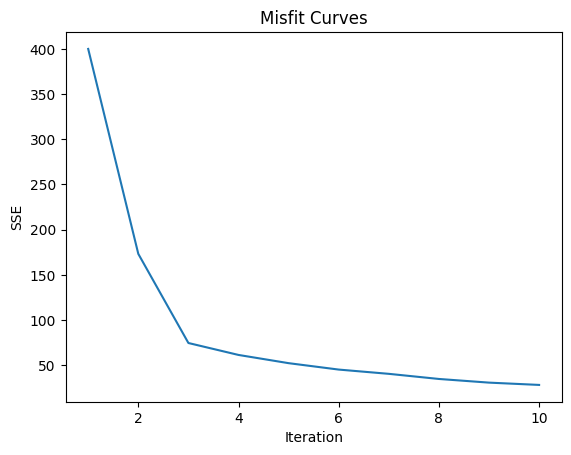

In [16]:
SSE = []

i = 1
while i < 10+1:
    kmeans = KMeans(
        init="random",
        n_clusters=i,
        n_init=10,
        max_iter=300,
        random_state=42
        )
    kmeans.fit(scaled_features)
    sse = kmeans.inertia_
    SSE.append(sse)

    # add to loop
    i+=1

plt.plot(range(1,11,1),SSE)
plt.title('Misfit Curves')
plt.xlabel('Iteration')
plt.ylabel('SSE')
plt.show()


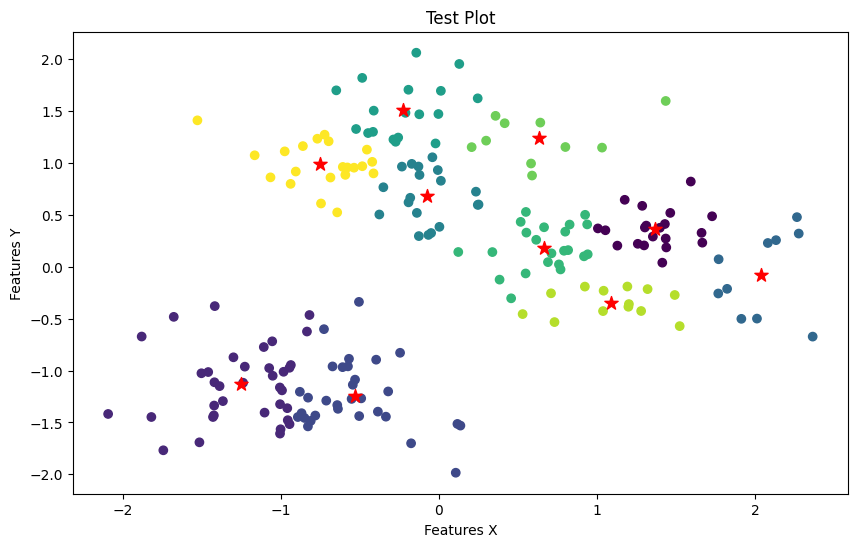

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(scaled_features[:,0], scaled_features[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],marker='*', color='red' ,s=100)
plt.title('Test Plot')
plt.xlabel('Features X')
plt.ylabel('Features Y')
plt.show()

This is a common situation in data fitting. We can reduce the misfit (Sum of Squared Errors) but increasing the number of model parameters, or in this case, number of clusters, `n_clusters`. However, this isn't always meaningful. 

In model fitting, we want to find the model with the **minimum number of model parameters** (`n_clusters`) to adequately explain the data.

In this case, we know that the correct value of n_clusters is 3. Notice the **elbow** or **knee** in the plot n_clusters=3. This value tells us that as we add more model paramters, the misfit (SSE) doesn't decrease as much any more. **This is the right number of n_clusters to use.**

<font color=goldenrod>**_Code for you to write_**</font>

Add an `axvline` to your plot at x=3 to show this knee/elbow.

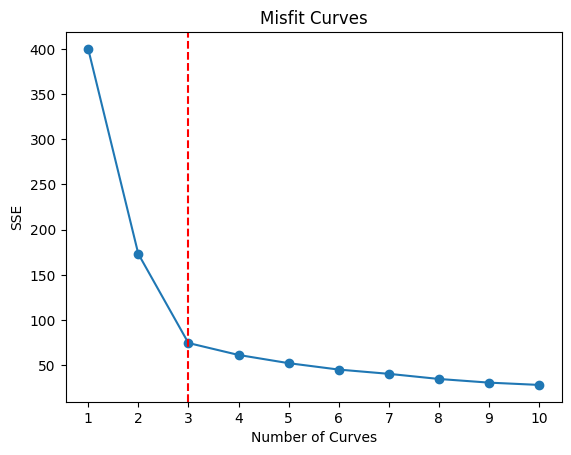

In [18]:
plt.plot(range(1,11,1),SSE)
plt.scatter(range(1,11,1),SSE)
plt.title('Misfit Curves')
plt.xlabel('Number of Curves')
plt.ylabel('SSE')
plt.xticks(range(1,11,1))
plt.axvline(x=3, linestyle='--', color='red')
plt.show()

### Clustering of seismic tomography models

Seismic tomography models contain lots of information that can be difficult to understand. Clustering helps us to make sense of the seismic velocities and relate them to tectonic processes.

We can download tomographic models from the Earthscope database.

https://ds.iris.edu/ds/products/emc-earthmodels/

The models are distributed as **Network Common Data Form** or **NetCDF** files. These are labelled **.nc** for short.

NetCDF can be read in using the model `xarray`, which we loaded as `xr`. Similar to csv files, NetCDF files contain different categories, but they are commonly used for array data, like geographic data.

In [28]:
model = xr.open_dataset("./data/semucb-2014-ucb-vs-viz-only.r0.1.nc")

We can look at the contents of the object.

In [29]:
model

<xarray.Dataset> Size: 20MB
Dimensions:    (depth: 74, latitude: 183, longitude: 365)
Coordinates:
  * depth      (depth) float32 296B 30.0 40.0 50.0 ... 2.841e+03 2.891e+03
  * latitude   (latitude) float32 732B -90.0 -89.01 -88.02 ... 88.2 89.19 90.0
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 179.4 180.0
Data variables:
    vs         (depth, latitude, longitude) float32 20MB ...
Attributes: (12/29)
    title:                         SEMUCB Global Model (version 1) - Voigt-av...
    summary:                       Whole-mantle radially anisotropic shear ve...
    keywords:                      Body waves; Surface waves and free oscilla...
    reference:                     French, S., & Romanowicz, B. A. (2014). Wh...
    author_name:                   Barbara Romanowicz
    author_email:                  barbarar@berkeley.edu
    ...                            ...
    geospatial_lat_max:            90.0
    geospatial_lon_min:            -180.0
    geospatial_lon_max:            180.0
    geospatial_vertical_min:       30.0
    geospatial_vertical_max:       2891.0
    history:                       2023-07-14 23:07:10 UTC Converted to netCD...

There are 3 sets of coordinate variables, depth, latitude, and longitude, and one data variable, **vs**. Each of the coordinates is only specified at the unique values. 

Meanwhile, the data variable **vs** is the Shear Wave velocity at each latitude, longitude, and depth. 

In [21]:
model["vs"]['depth']

<xarray.DataArray 'depth' (depth: 74)> Size: 296B
array([  30.,   40.,   50.,   60.,   70.,   80.,   90.,  100.,  110.,  130.,
        150.,  170.,  190.,  210.,  230.,  250.,  270.,  290.,  310.,  330.,
        350.,  370.,  390.,  410.,  441.,  491.,  541.,  591.,  641.,  691.,
        741.,  791.,  841.,  891.,  941.,  991., 1041., 1091., 1141., 1191.,
       1241., 1291., 1341., 1391., 1441., 1491., 1541., 1591., 1641., 1691.,
       1741., 1791., 1841., 1891., 1941., 1991., 2041., 2091., 2141., 2191.,
       2241., 2291., 2341., 2391., 2441., 2491., 2541., 2591., 2641., 2691.,
       2741., 2791., 2841., 2891.], dtype=float32)
Coordinates:
  * depth    (depth) float32 296B 30.0 40.0 50.0 ... 2.841e+03 2.891e+03
Attributes:
    long_name:  depth below earth surface
    units:      km
    positive:   down

In [22]:
model["vs"]['latitude']

<xarray.DataArray 'latitude' (latitude: 183)> Size: 732B
array([-90.  , -89.01, -88.02, -87.03, -86.04, -85.05, -84.06, -83.07, -82.08,
       -81.09, -80.1 , -79.11, -78.12, -77.13, -76.14, -75.15, -74.16, -73.17,
       -72.18, -71.19, -70.2 , -69.21, -68.22, -67.23, -66.24, -65.25, -64.26,
       -63.27, -62.28, -61.29, -60.3 , -59.31, -58.32, -57.33, -56.34, -55.35,
       -54.36, -53.37, -52.38, -51.39, -50.4 , -49.41, -48.42, -47.43, -46.44,
       -45.45, -44.46, -43.47, -42.48, -41.49, -40.5 , -39.51, -38.52, -37.53,
       -36.54, -35.55, -34.56, -33.57, -32.58, -31.59, -30.6 , -29.61, -28.62,
       -27.63, -26.64, -25.65, -24.66, -23.67, -22.68, -21.69, -20.7 , -19.71,
       -18.72, -17.73, -16.74, -15.75, -14.76, -13.77, -12.78, -11.79, -10.8 ,
        -9.81,  -8.82,  -7.83,  -6.84,  -5.85,  -4.86,  -3.87,  -2.88,  -1.89,
        -0.9 ,   0.09,   1.08,   2.07,   3.06,   4.05,   5.04,   6.03,   7.02,
         8.01,   9.  ,   9.99,  10.98,  11.97,  12.96,  13.95,  14.94,  15.93,
        16.92,  17.91,  18.9 ,  19.89,  20.88,  21.87,  22.86,  23.85,  24.84,
        25.83,  26.82,  27.81,  28.8 ,  29.79,  30.78,  31.77,  32.76,  33.75,
        34.74,  35.73,  36.72,  37.71,  38.7 ,  39.69,  40.68,  41.67,  42.66,
        43.65,  44.64,  45.63,  46.62,  47.61,  48.6 ,  49.59,  50.58,  51.57,
        52.56,  53.55,  54.54,  55.53,  56.52,  57.51,  58.5 ,  59.49,  60.48,
        61.47,  62.46,  63.45,  64.44,  65.43,  66.42,  67.41,  68.4 ,  69.39,
        70.38,  71.37,  72.36,  73.35,  74.34,  75.33,  76.32,  77.31,  78.3 ,
        79.29,  80.28,  81.27,  82.26,  83.25,  84.24,  85.23,  86.22,  87.21,
        88.2 ,  89.19,  90.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 732B -90.0 -89.01 -88.02 ... 88.2 89.19 90.0
Attributes:
    long_name:      Latitude; positive north
    units:          degrees_north
    standard_name:  latitude

Let's just extract the `vs` values.

In [23]:
vs=model["vs"]
vs

<xarray.DataArray 'vs' (depth: 74, latitude: 183, longitude: 365)> Size: 20MB
[4942830 values with dtype=float32]
Coordinates:
  * depth      (depth) float32 296B 30.0 40.0 50.0 ... 2.841e+03 2.891e+03
  * latitude   (latitude) float32 732B -90.0 -89.01 -88.02 ... 88.2 89.19 90.0
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 179.4 180.0
Attributes:
    variable:      vs
    long_name:     Voigt average shear wave velocity (isotropic Vs)
    display_name:  Vs (km/s)
    units:         kmps

We can select the variable values at specific coordinate in the xarray using `xarr.sel(coordinate_name=value)`

For example, the code below finds the shear wave velocities at `latitude = -90`

We can then extract the data values with `.data`.

In [24]:
vs.sel(latitude=-90.0)

<xarray.DataArray 'vs' (depth: 74, longitude: 365)> Size: 108kB
[27010 values with dtype=float32]
Coordinates:
  * depth      (depth) float32 296B 30.0 40.0 50.0 ... 2.841e+03 2.891e+03
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 179.4 180.0
    latitude   float32 4B -90.0
Attributes:
    variable:      vs
    long_name:     Voigt average shear wave velocity (isotropic Vs)
    display_name:  Vs (km/s)
    units:         kmps

<font color=goldenrod>**_Code for you to write_**</font>

Complete the code below to select where in xarray `vs` the `depth` is 80, extract the data, and save it as `vs_80`.

In [30]:
vs_80=vs.sel(depth=80)
print(vs_80)

<xarray.DataArray 'vs' (latitude: 183, longitude: 365)> Size: 267kB
[66795 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 732B -90.0 -89.01 -88.02 ... 88.2 89.19 90.0
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 179.4 180.0
    depth      float32 4B 80.0
Attributes:
    variable:      vs
    long_name:     Voigt average shear wave velocity (isotropic Vs)
    display_name:  Vs (km/s)
    units:         kmps


We can take a look at the shape of this array.

In [31]:
print(np.shape(vs_80))

(183, 365)


This looks geographic to me. We can now plot the shear wave velocities on a map.

We need to first create the mesh of lats and lons to plot at, this is easy with `np.meshgrid`.

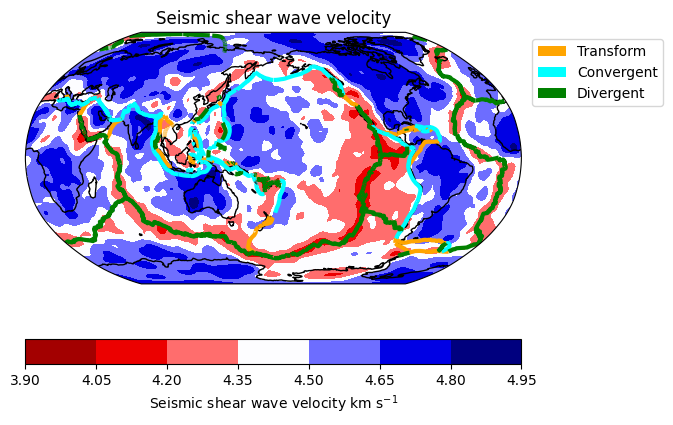

In [39]:
#Create mesh of lons and lats for each vs value
lons, lats = np.meshgrid(vs.longitude.data, vs.latitude.data)

#Plot these
ax = plt.axes( projection=ccrs.Robinson(central_longitude=180) )
ax.coastlines()
plt.title("Seismic shear wave velocity")
plt.contourf(lons,lats,vs_80,cmap='seismic_r', transform=ccrs.PlateCarree())
plt.colorbar(label="Seismic shear wave velocity km s$^{-1}$", orientation="horizontal")  

#------- Plot plate boundaries
from cartopy.io.shapereader import Reader
import matplotlib.patches as mpatches
data = Reader('../week03_visual_seismo/data/Plate_Boundaries_transform.shp')
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='orange', facecolor='none',
                  linewidth=3)

data = Reader('../week03_visual_seismo/data/Plate_Boundaries_trenches.shp')
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='cyan', facecolor='none',
                  linewidth=3)

data = Reader('../week03_visual_seismo/data/Plate_Boundaries_ridges.shp')
ax.add_geometries(data.geometries(), crs=ccrs.PlateCarree(), 
                  edgecolor='green', facecolor='none',
                  linewidth=3)

# make patches to add to a legend
trans = mpatches.Rectangle((0, 0), 1, 1, facecolor="orange")
con = mpatches.Rectangle((0, 0), 1, 1, facecolor="cyan")
div = mpatches.Rectangle((0, 0), 1, 1, facecolor="green")
labels = ['Transform','Convergent','Divergent']
plt.legend([trans, con, div], labels, bbox_to_anchor=(1.3, 1))
#------- Plot plate boundaries

plt.show()

<font color=red>**_Question_**</font> What patterns do you see and how does this compare with the positions of the continents?

We can also use the `xarray` format to slice the data.

In [40]:
# Select based on multiple dimensions
vs_80_subset=vs.sel(depth=80, latitude=slice(-85, 85), longitude=slice(-180, 0))

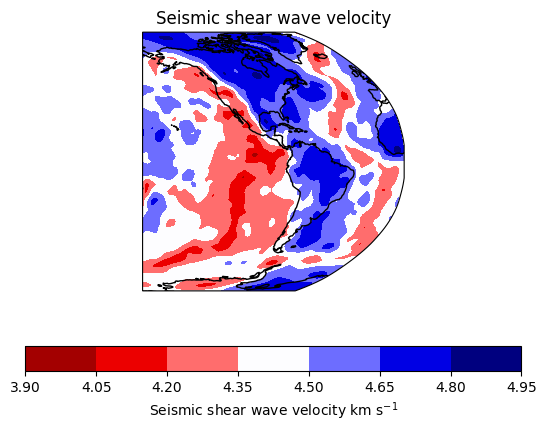

In [41]:
#Create mesh of lons and lats for each vs value
lons_subset, lats_subset = np.meshgrid(vs_80_subset.longitude.data, vs_80_subset.latitude.data)

#Plot these
ax = plt.axes( projection=ccrs.Robinson(central_longitude=180) )
ax.coastlines()
plt.title("Seismic shear wave velocity")
plt.contourf(lons_subset,lats_subset,vs_80_subset,cmap='seismic_r', transform=ccrs.PlateCarree())
plt.colorbar(label="Seismic shear wave velocity km s$^{-1}$", orientation="horizontal")  

plt.show()

### K-means clustering of the models
Now that we've plotted the data, let's try to simplify the complicated patterns of seismic velocities into something that we can more easily understand.

In [44]:
vs_80

<xarray.DataArray 'vs' (latitude: 183, longitude: 365)> Size: 267kB
array([[4.664753, 4.664753, 4.664753, ..., 4.664753, 4.664753, 4.664753],
       [4.626048, 4.625549, 4.625057, ..., 4.62688 , 4.626369, 4.626048],
       [4.582584, 4.581537, 4.580504, ..., 4.584329, 4.583258, 4.582584],
       ...,
       [4.605399, 4.606864, 4.608287, ..., 4.602909, 4.604444, 4.605399],
       [4.561086, 4.561779, 4.562458, ..., 4.559919, 4.560637, 4.561086],
       [4.524088, 4.524088, 4.524088, ..., 4.524088, 4.524088, 4.524088]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float32 732B -90.0 -89.01 -88.02 ... 88.2 89.19 90.0
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 179.4 180.0
    depth      float32 4B 80.0
Attributes:
    variable:      vs
    long_name:     Voigt average shear wave velocity (isotropic Vs)
    display_name:  Vs (km/s)
    units:         kmps

In [45]:
n_clusters = 3

# Normalize information
scaler = StandardScaler()
vs_80_values = vs_80.data.reshape(1,len(vs.latitude)*len(vs.longitude)).T
scaled_vs = scaler.fit_transform(vs_80_values)
# Set up kmeans operator
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=50,
    max_iter=300 )

# Run analysis
kmeans.fit(scaled_vs)


,n_clusters,3
,init,'random'
,n_init,50
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


Let's look at the outputs

In [46]:
print(kmeans.inertia_)
print(kmeans.labels_)
print(np.shape(kmeans.labels_))

9403.880859375
[0 0 0 ... 1 1 1]
(66795,)


Now we can plot up the cluster labels in the same way.

/tmp/ipykernel_862855/3813900562.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


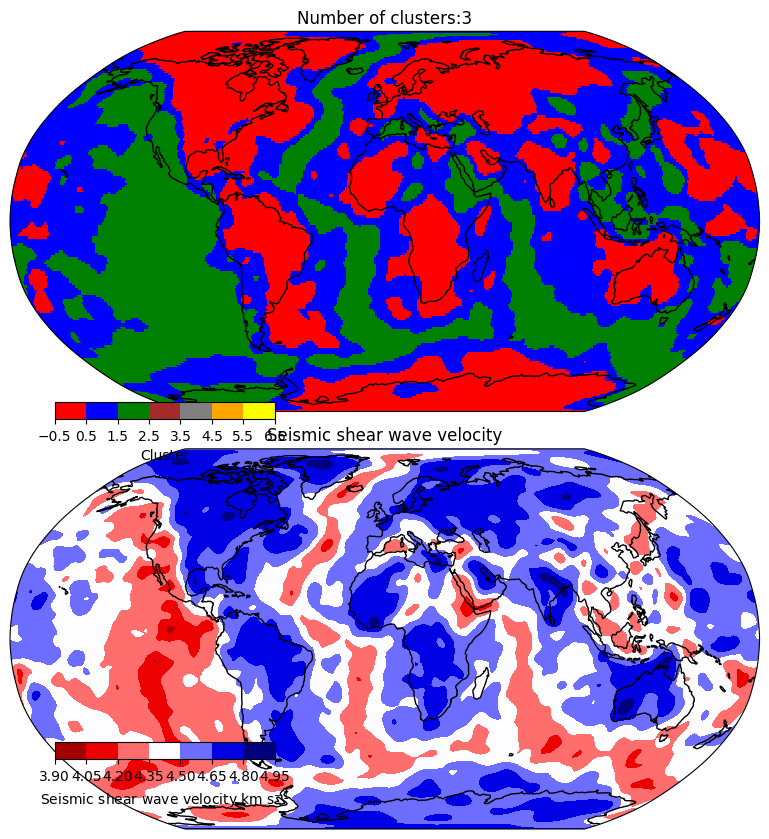

In [49]:
lons, lats = np.meshgrid( vs.longitude.data, vs.latitude.data)

labels = np.reshape(kmeans.labels_, np.shape(lons) )

fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(11,8.5))

# create colormap
cmap = colors.ListedColormap(['red','blue', 'green','brown', 'gray', 'orange', 'yellow'])
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

#Plot clusters
cbar_ax0 = fig.add_axes([0.2, 0.5, 0.2, 0.02])
axs[0].coastlines()
axs[0].set_title("Number of clusters:" + str(n_clusters) )
cs0=axs[0].pcolormesh(lons, lats, labels, transform=ccrs.PlateCarree(),  cmap=cmap, norm=norm)
fig.colorbar(cs0,cax=cbar_ax0,label="Cluster", orientation="horizontal")  

#Plot seismic velocities
cbar_ax1 = fig.add_axes([0.2, 0.1, 0.2, 0.02])
axs[1].coastlines()
axs[1].set_title("Seismic shear wave velocity")
cs1=axs[1].contourf(lons,lats,vs_80,cmap='seismic_r', transform=ccrs.PlateCarree())
fig.colorbar(cs1,cax=cbar_ax1,label="Seismic shear wave velocity km s$^{-1}$", orientation="horizontal")  

plt.tight_layout()
plt.show()

<font color=red>**_Question_**</font> Does the number of clusters adequately describe the velocities?

Yes

One of the strengths of NetCDF is that all of the coordinates and values are in the same object. We can use `dir(netcdf_object)` to look at the functions available.

In [50]:
dir(model["vs"])

['T',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__'

We're going to use `netcdf_object.interp` to interpolate onto a different set of depth coordinates than those given in the file.

In [55]:
vs.interp?

Signature:
vs.interp(
    coords: 'Mapping[Any, Any] | None' = None,
    method: 'InterpOptions' = 'linear',
    assume_sorted: 'bool' = False,
    kwargs: 'Mapping[str, Any] | None' = None,
    **coords_kwargs: 'Any',
) -> 'Self'
Docstring:
Interpolate a DataArray onto new coordinates.

Performs univariate or multivariate interpolation of a Dataset onto new coordinates,
utilizing either NumPy or SciPy interpolation routines.

Out-of-range values are filled with NaN, unless specified otherwise via `kwargs` to the numpy/scipy interpolant.

Parameters
----------
coords : dict, optional
    Mapping from dimension names to the new coordinates.
    New coordinate can be a scalar, array-like or DataArray.
    If DataArrays are passed as new coordinates, their dimensions are
    used for the broadcasting. Missing values are skipped.
method : { "linear", "nearest", "zero", "slinear", "quadratic", "cubic",             "quintic", "polynomial", "pchip", "barycentric", "krogh", "akima", "makima" }

Let's look at the depths already in the dataset.

In [56]:
vs['depth']

<xarray.DataArray 'depth' (depth: 74)> Size: 296B
array([  30.,   40.,   50.,   60.,   70.,   80.,   90.,  100.,  110.,  130.,
        150.,  170.,  190.,  210.,  230.,  250.,  270.,  290.,  310.,  330.,
        350.,  370.,  390.,  410.,  441.,  491.,  541.,  591.,  641.,  691.,
        741.,  791.,  841.,  891.,  941.,  991., 1041., 1091., 1141., 1191.,
       1241., 1291., 1341., 1391., 1441., 1491., 1541., 1591., 1641., 1691.,
       1741., 1791., 1841., 1891., 1941., 1991., 2041., 2091., 2141., 2191.,
       2241., 2291., 2341., 2391., 2441., 2491., 2541., 2591., 2641., 2691.,
       2741., 2791., 2841., 2891.], dtype=float32)
Coordinates:
  * depth    (depth) float32 296B 30.0 40.0 50.0 ... 2.841e+03 2.891e+03
Attributes:
    long_name:  depth below earth surface
    units:      km
    positive:   down

We can interpolate the model onto depths that don't exist, such as 200 km depth

In [57]:
value_3D = vs.interp(depth = 200).data

We can create a **range of depths** to interpolate onto and use the `.interp` method to apply this.

In [58]:
vs = model["vs"]
depth = np.arange(50,200,50)

value_3D = vs.interp(depth = depth).data


Let's reshape this into a format that kmeans can use, which is a long array.

In [59]:
value_3D = value_3D.reshape(len(depth),len(vs.latitude)*len(vs.longitude)).T

Now let's set up the kmeans clustering for the velocities at a range of depths.

In [60]:
n_clusters = 3

# Normalize information
scaler = StandardScaler()
scaled_vs = scaler.fit_transform(value_3D)
# Set up kmeans operator
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=50,
    max_iter=300 )

# Run analysis
kmeans.fit(scaled_vs)

,n_clusters,3
,init,'random'
,n_init,50
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


We can plot this again.

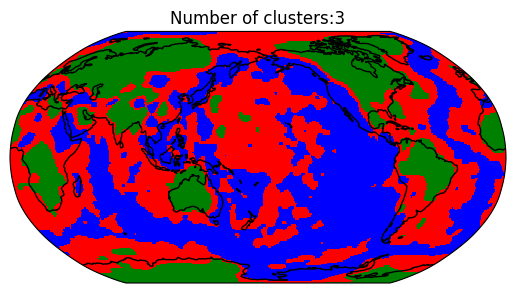

CPU times: user 6.54 s, sys: 179 ms, total: 6.71 s
Wall time: 14.1 s


In [61]:
%%time
lons, lats = np.meshgrid( vs.longitude.data, vs.latitude.data)

labels = np.reshape(kmeans.labels_, np.shape(lons) )

# create colormap
cmap = colors.ListedColormap(['red','blue', 'green','brown', 'gray', 'orange', 'yellow'])
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

ax = plt.axes( projection=ccrs.Robinson(central_longitude=180) )
ax.coastlines()
plt.title("Number of clusters:" + str(n_clusters) )
plt.pcolormesh(lons, lats, labels, transform=ccrs.PlateCarree(),  cmap=cmap, norm=norm)

plt.show()


<font color=goldenrod>**_Code for you to write_**</font>

- Calculate the best k value by running loop between k of 1 and 7 (inclusive).
- Plot the misfit curve and find the elbow

In [ ]:
loop_count = range(1,7,1)

SSE = []
for i in loop_count:
    print(i)
    n_clusters = i

    # Normalize information
    scaler = StandardScaler()
    scaled_vs = scaler.fit_transform(value_3D)
    # Set up kmeans operator
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=50,
        max_iter=300 )
    
    # Run analysis
    kmeans.fit(scaled_vs)
    sse = kmeans.inertia_
    SSE.append(sse)

1
2
3
4
5


In [ ]:
plt.plot(loop_count, SSE)
plt.xlabel('# of Clusters')
plt.ylable('Sum of squared distances of samples')
plt.show()

### Patterns in the deep mantle

The Earth's Core-Mantle boundary, at 2891 km depth, is also a very interesting place. It's where the heat that drives mantle convection enters the mantle, so ultimately controls this process. 

<font color=goldenrod>**_Code for you to write_**</font>

Repeat the analysis from above using the vs at 2891 km depth. Plot the velocities, repeat the kmeans calculate for a range of ks, plot the SSE versus k curve, find the best number of k, and plot the clusters for that k.

In [ ]:
vs_2891=vs.sel(depth=2891).data
print(vs_2891)

The seismic velocities in the lower mantle can be described by a degree-2 pattern, much like in the upper mantle. These Large Low Shear Velocity Provinces are sometimes referred to as "anti continents" because they appear similar in scale and pattern to the Earth's surface continents. We still don't know what these objects are or how they got there. It's the subject of active research.

For more information see this paper: https://www.nature.com/articles/ngeo2733

### Turn in this notebook

Save your completed notebook, print the file to PDF, and upload the PDF on Blackboard.